# Linear Models

### **Actividad Semanal #7**

* Nombre: Rafael J. Mateo C
* Matrícula: A01793054
* Materia: Ciencia y Analítica de Datos
* Profesor: María de la Paz
* Fecha: 7 Nov 2022


# Ejercicio 1

Utiliza la base de datos de 
https://www.kaggle.com/vinicius150987/manufacturing-cost

Suponga que trabaja como consultor de una empresa de nueva creación que busca desarrollar un modelo para estimar el costo de los bienes vendidos a medida que varían el volumen de producción (número de unidades producidas). La startup recopiló datos y le pidió que desarrollara un modelo para predecir su costo frente a la cantidad de unidades vendidas.

#### 1. Importación y Análisis de los Datos

Comenzaremos primero importando los datos y las librerías que usaremos.

In [1]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns

A continuación, definiremos algunas funciones que estaremos usando más adelante.

In [2]:
def plot_model(x, y_real, y_pred, title):
    
    #Grafica un diagrama de correlación
    plt.scatter(x, y_real, alpha = 0.5)
    plt.plot(x, y_pred, "r-", linewidth=2, label="Predictions")
    
    plt.legend(loc = "upper right")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.title(title)
    
    plt.show()
    
def display_metric_plots(scores):
    

    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3)

        #Grafica las diferentes métricas en un diagrama de barras
    ax1.set_title('Comparación MAE por modelo')
    ax1.barh(scores["names"], scores["MAE"])

    ax2.set_title('Comparación R^2 por modelo')
    ax2.barh(scores["names"], scores["R2"])

    #Grafica los residuos en un diagrama de caja
    ax3.set_title('Diagrama de caja de los residuos')
    ax3.boxplot(scores['res'], labels=scores['names'], showmeans = True)
    ax3.figure.set_figheight(15)
    
    plt.show()

#Obtiene los coeficientes e interceptos de los modelos
def get_linear_model_eq(model):
    return [model.coef_, model.intercept_]

#Esta función imprime los valores de las métricas calculadas
def print_metrics(y_real, y_pred):
    print('Error medio Absoluto (MAE):', mean_absolute_error(y_real, y_pred))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_real, y_pred)))
    print('r2_score',r2_score(y_real, y_pred))
    
 #Ordena la data de menor a mayor   
def sort_data(X, y_real, y_pred):
    
    order = np.argsort(X)

    x_sorted = X[order]
    y_real_sorted = y_real[order]
    y_pred_sorted = y_pred[order]

    return x_sorted, y_real_sorted, y_pred_sorted

Ahora importamos los datos que estaremos utilizando

In [3]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/marypazrf/bdd/main/EconomiesOfScale.csv')
df.sample(10)

,Number of Units,Manufacturing Cost
142,3.063801,40.933678
950,6.727705,31.494308
122,2.943189,38.825026
642,4.977296,32.276264
803,5.554847,35.304973
35,2.004804,60.021543
17,1.739201,60.572597
835,5.664530,36.483292
69,2.544661,50.414450
96,2.762052,50.216171


In [4]:
X = df[['Number of Units']]
y = df['Manufacturing Cost']

In [5]:
len(X)

1000

Ahora, revisamos las estadísticas descriptivas de los datos. 

In [6]:
y.describe()

count    1000.000000
mean       40.052999
std        10.595322
min        20.000000
25%        32.912036
50%        38.345781
75%        44.531822
max       100.000000
Name: Manufacturing Cost, dtype: float64

De lo anterior podemos observar que los costos varían de 20 a 100 y tanto la media como la mediana tienen valores similares. Esto significa que los datos no tienen alta variación, o bien, presencia de atípicos. Ahora observemos el comportamiento de los datos con un diagrama de correlación.

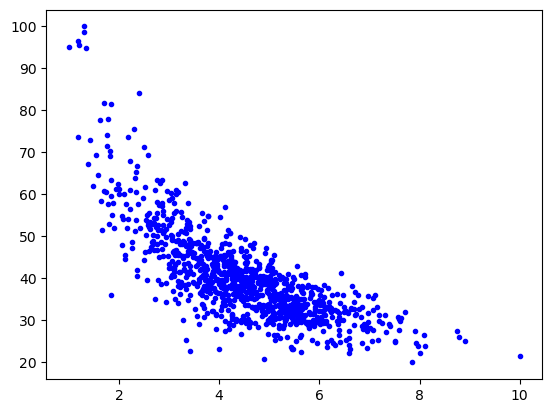

In [7]:
plt.plot(X,y,'b.')

De lo anterior podemos apreciar que los datos tienen un comportamiento ligeramente curveado, por lo que es muy probable que un polinmio de orden 2 tenga mejor desempeño que un modelo lineal. Ahora hagamos la partición de los datos.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#Aquí almacenaremos los scores
scores = {
    'MAE': [], 
    'R2': [],
    'res': [],
    'names': ["Modelo Lineal", "Modelo Cuadrático", "Modelo Ridge", "Modelo Lasso"]}

Ahora entrenaremos el modelo lineal

In [9]:
#Modelo lineal
lr_model = LinearRegression()

#Entrenamos el modelo y obtenemos las predicciones
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

#Almacenamos las métricas y residuos
scores["MAE"].append(mean_absolute_error(y_test, y_pred))
scores["R2"].append(r2_score(y_test, y_pred))
scores["res"].append(y_test - y_pred)

Ahora obtendremos el coeficiente e intercepto para determinar la ecuación.

In [10]:
get_linear_model_eq(lr_model)

[array([-6.03357276]), 67.03883293539208]

La ecuación del modelo anterior es: $\hat{y} =  67.038 - 6.033X$

Ahora generemos el gráfico del modelo

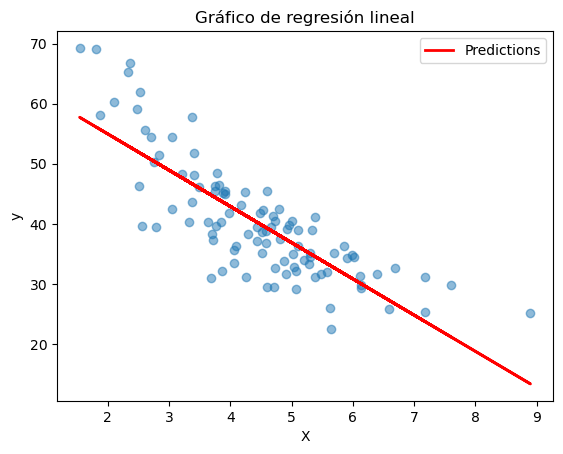

In [11]:
plot_model(X_test, y_test, y_pred, "Gráfico de regresión lineal")

Del gráfico anterior se observa que los datos de prueba se ajustan al modelo lineal, aunque en la parte superior izquierda se pueden observar algunos puntos que se salen del patrón. Veamos ahora las métricas para este modelo.

In [12]:
print_metrics(y_test, y_pred)

Error medio Absoluto (MAE): 4.581575620531287
Root Mean Squared Error: 5.820691087508853
r2_score 0.6544705154382865


A continuación, entrenaremos un modelo de orden 2.

In [13]:
#polinomial
pipe = Pipeline(steps = [
    ("pol_transform", PolynomialFeatures(include_bias=False)),
    ('model', LinearRegression())
])

#Entrenamos el modelo
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test) 

#Almacenamos las métricas y residuos
scores["MAE"].append(mean_absolute_error(y_test, y_pred))
scores["R2"].append(r2_score(y_test, y_pred))
scores["res"].append(y_test - y_pred)


Ahora obtengamos la ecuación del modelo

In [14]:
[pipe.named_steps['model'].coef_, pipe.named_steps['model'].intercept_]

[array([-16.95147175,   1.18852154]), 89.97388061400437]

La ecuación del modelo anterior es: $\hat{y} =  -17.82X + 1.27X^2 + 92$

Ahora veamos su gráfico, pero primero ordenemos los datos para evitar que el gráfico se distorcione.

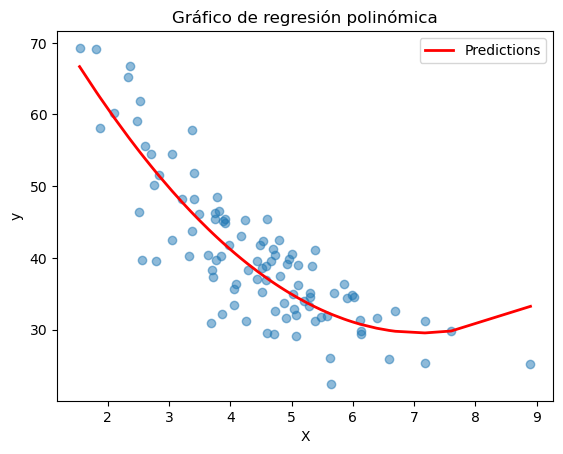

In [15]:

x_sorted, y_real_sorted, y_pred_sorted = sort_data(X_test.values.ravel(), y_test.values.ravel(), y_pred)

plot_model(x_sorted, y_real_sorted, y_pred_sorted, "Gráfico de regresión polinómica")

Del gráfico anterior podemos ver que el modelo se ajusta mejor, principalmente para los puntos de arriba que en el modelo lineal quedaban muy lejos de la curva. Procedamos a calcular las métricas para este modelo.

In [16]:
print_metrics(y_test, y_pred)

Error medio Absoluto (MAE): 4.070921827959767
Root Mean Squared Error: 5.101935770152972
r2_score 0.7345357864097419


A continuación estaremos entrenando los modelos Ridge y Lasso

In [17]:
#Modelo Ridge
lr_ridge = Ridge()

#Entrenamos el modelo y obtenemos las predicciones
lr_ridge.fit(X_train, y_train)
y_pred = lr_ridge.predict(X_test)

#Almacenamos las métricas y residuos
scores["MAE"].append(mean_absolute_error(y_test, y_pred))
scores["R2"].append(r2_score(y_test, y_pred))
scores["res"].append(y_test - y_pred)

In [18]:
#Obtenemos los coeficientes
get_linear_model_eq(lr_ridge)

[array([-6.02982087]), 67.0220338533617]

La ecuación del modelo ridge es: $\hat{y} =  67.02 - 6.03X$

Obtengamos las métricas y su gráfico.

In [19]:
print_metrics(y_test, y_pred)

Error medio Absoluto (MAE): 4.581736558347315
Root Mean Squared Error: 5.820690906561836
r2_score 0.6544705369211404


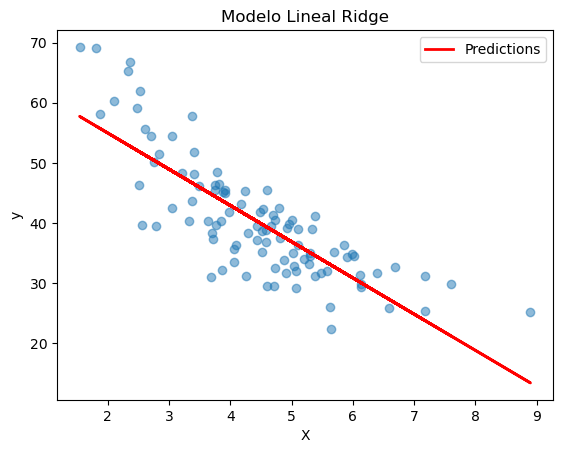

In [20]:
plot_model(X_test, y_test, y_pred, title="Modelo Lineal Ridge")

El modelo ridge tuvo un comportamiento muy similar al modelo lineal. Entrenemos ahora el modelo Lasso.

In [21]:
lr_lasso = Lasso()

lr_lasso.fit(X_train, y_train)
y_pred = lr_lasso.predict(X_test)

scores["MAE"].append(mean_absolute_error(y_test, y_pred))
scores["R2"].append(r2_score(y_test, y_pred))
scores["res"].append(y_test - y_pred)

In [22]:
get_linear_model_eq(lr_lasso)

[array([-5.47357151]), 64.53143277158046]

La ecuación del modelo lasso es: $\hat{y} =  64.53 - 5.47X$

In [23]:
print_metrics(y_test, y_pred)

Error medio Absoluto (MAE): 4.630348756803918
Root Mean Squared Error: 5.867738730534317
r2_score 0.6488622307077648


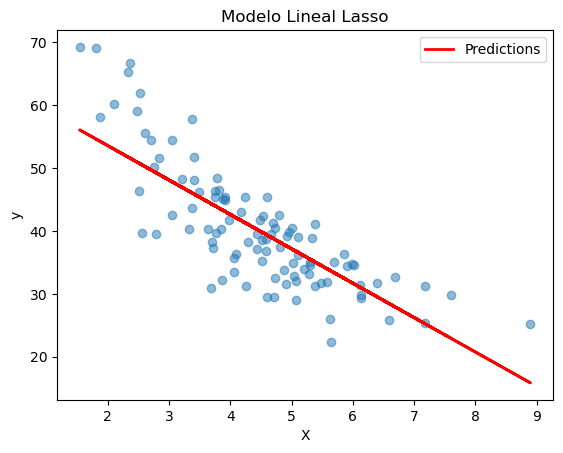

In [24]:
plot_model(X_test, y_test, y_pred, title="Modelo Lineal Lasso")

Al igual que ridge, tuvo un comportamiento similar al modelo lineal. Hagamos un comparativo de las métricas.

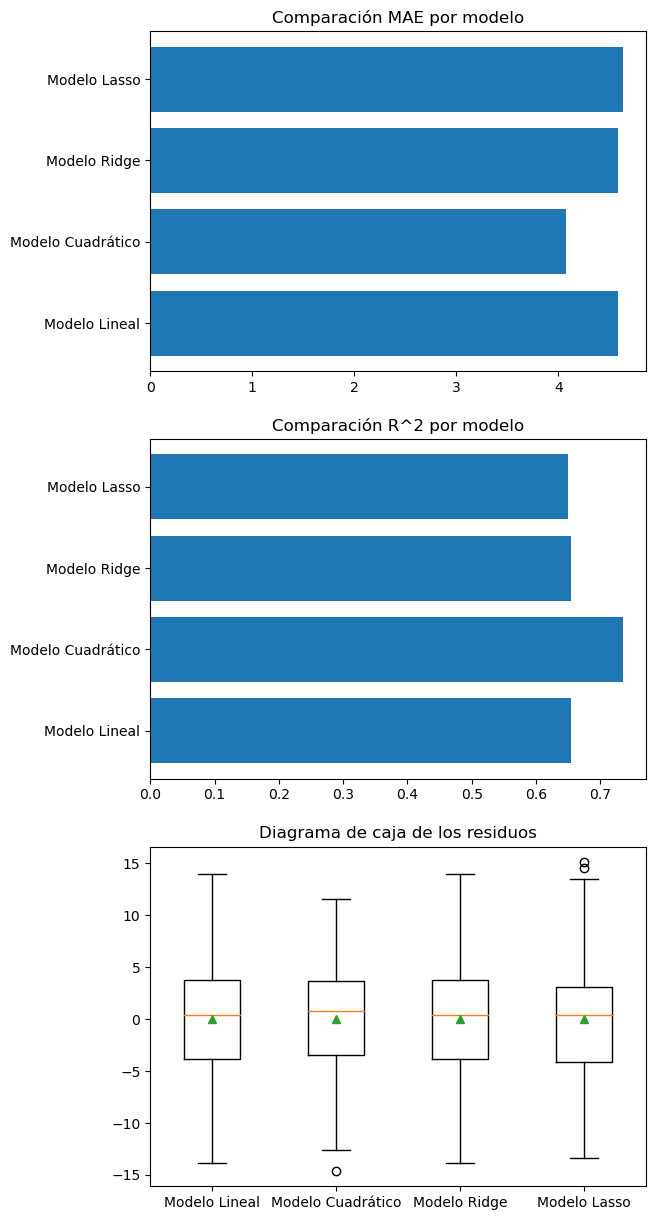

In [25]:
display_metric_plots(scores)

De lo anterior se observa que el modelo cuadrático fue el que tuvo mejor desempeño. Veamos el comportamiento de los residuos, viendo el histograma y su correlación.

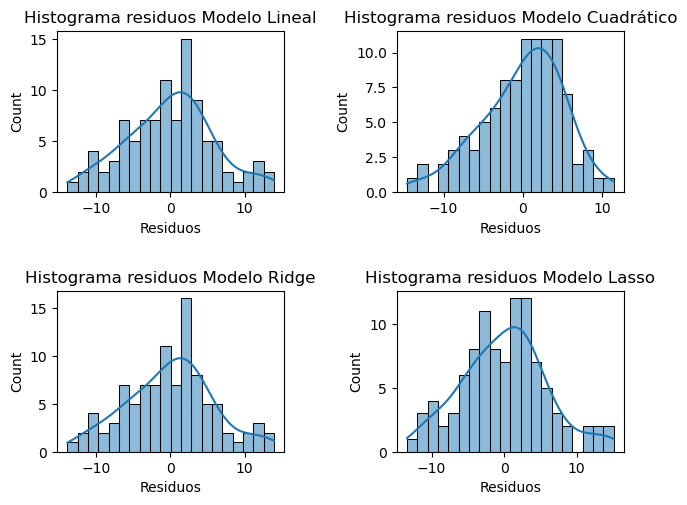

In [26]:
#Hacemos un panel que tenga dos columnas y dos filas
fig, ax = plt.subplots(2,2)
#Ajustamos el layout
plt.tight_layout(h_pad=5, w_pad=5)
count = 0
#Ploteamos el gráfico en cada panel
for i in range(2):
    for j in range(2):
        ax[i][j].set_title(f'Histograma residuos {scores["names"][count]}')
        ax[i][j].set_xlabel('Residuos')
        sns.histplot(scores['res'][count], bins = 20, kde=True, ax= ax[i][j])
        count = count + 1

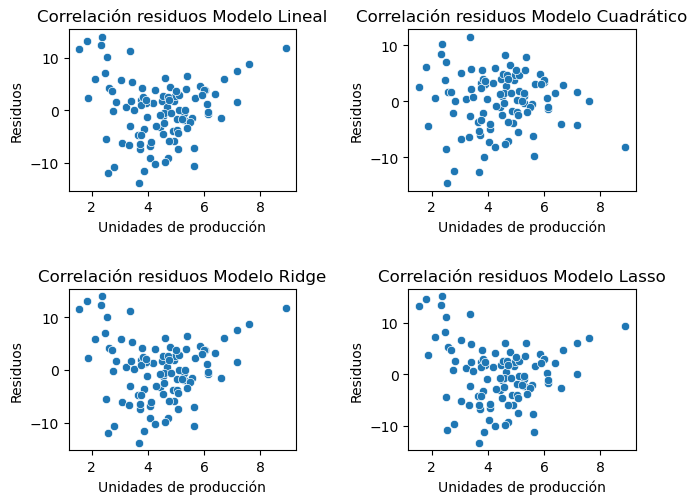

In [27]:
fig, ax = plt.subplots(2,2)
plt.tight_layout(h_pad=5, w_pad=5)
count = 0
for i in range(2):
    for j in range(2):
        ax[i][j].set_title(f'Correlación residuos {scores["names"][count]}')
        ax[i][j].set_xlabel('Unidades de producción')
        ax[i][j].set_ylabel('Residuos')
        sns.scatterplot(x = X_test.values.ravel(), y = scores['res'][count], ax= ax[i][j])
        count = count + 1

Se observa que los residuos siguen una distribución tipo camapa y no se evidencia correlación entre ellos.

### Conclusiones ###

* Se eligió una partición de los datos de entrenamiento/prueba de 80/20 respectivamente. Esto para mantener un equilibrio entre sesgo y varianza, ya que el contar con más datos de entrenamiento disminuye la varianza, pero si se tiene muy pocos datos para validación entonces el sesgo aumenta. La partición 80/20 es la más usada en la práctica.
  
* El modelo que mostró mejor desempeño fue el cuadrático, ya que este presenta el menor error entre todos los modelos, así como un coeficiente de determinación más alto. Por ejemplo, el modelo cuadrático explica alrededor del 73% de la variación de los datos, con un MAE de 4.03. Los demás modelos explican menos del 70% de la variación y su MAE es por encima de 4.
  
* Con relación a si el error aceptable o no, esto es algo que debería evaluarse con el negocio. El MAE de 4.03 significa un desfase de las predicciones realizadas por el modelo de un promedio de USD 4.03 (suponiendo que la moneda sea dólares). El negocio debe decidir si este error es tolareble o no para las predicciones que desea realizar.
  
* Revisando las suposiciones del modelo, se observa que todos los gráficos siguen una distribución mas o menos uniforme, tipo campana. También del diagrama de correlación no se puede apreciar patrones que indiquen una correlación de los residuos.

# Ejercicio 2

Realiza la regresión polinomial de los siguientes datos:

In [28]:
df = pd.read_csv('https://raw.githubusercontent.com/marypazrf/bdd/main/kc_house_data.csv')
df.sample(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
13620,7011201475,20140527T000000,780000.0,3,3.00,2520,2152,1.5,0,0,...,8,1560,960,1925,2006,98119,47.6363,-122.371,1140,2152
683,3438500486,20141016T000000,413000.0,4,3.50,2380,5809,2.0,0,0,...,7,1750,630,1995,0,98106,47.5536,-122.359,1620,5775
19941,7237450600,20141030T000000,450000.0,5,2.75,2710,6220,2.0,0,0,...,8,2710,0,2014,0,98038,47.3555,-122.061,2530,4759
3880,7774200236,20141211T000000,357000.0,3,1.50,1340,11744,1.0,0,0,...,7,1340,0,1950,0,98146,47.4947,-122.360,2020,13673
17876,5700000245,20140602T000000,540000.0,4,1.75,1720,4240,1.5,0,0,...,7,1460,260,1925,0,98144,47.5790,-122.294,1930,4280
642,4140090320,20150320T000000,595000.0,5,2.75,3740,6750,1.0,0,0,...,8,1980,1760,1978,0,98028,47.7679,-122.261,2620,7920
7575,2391600330,20150410T000000,505000.0,2,1.00,810,5060,1.0,0,0,...,6,810,0,1941,0,98116,47.5635,-122.394,900,5060
13605,2724079061,20141010T000000,610000.0,3,1.75,1650,221720,1.0,0,0,...,7,1650,0,1992,0,98024,47.5297,-121.901,2520,221284
17121,5096300130,20140714T000000,413000.0,3,2.00,1520,3451,1.0,0,0,...,8,1520,0,1996,0,98177,47.7753,-122.375,1800,3451
2925,5103300090,20140801T000000,699000.0,5,2.50,3340,24755,2.0,0,0,...,10,3340,0,2002,0,98038,47.4565,-122.066,3420,23274


Veamos un resumen de la estructura del conjunto de datos

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

Revisemos las estadísticas descriptiva de los datos

In [30]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


Eliminamos algunas columnas que no estaremos usando

In [31]:
df.drop('id', axis = 1, inplace = True)
df.drop('date', axis = 1, inplace = True)
df.drop('zipcode', axis = 1, inplace = True)
df.drop('lat', axis = 1, inplace = True)
df.drop('long', axis = 1, inplace = True)


Revisamos la correlación entre cada una de las variables

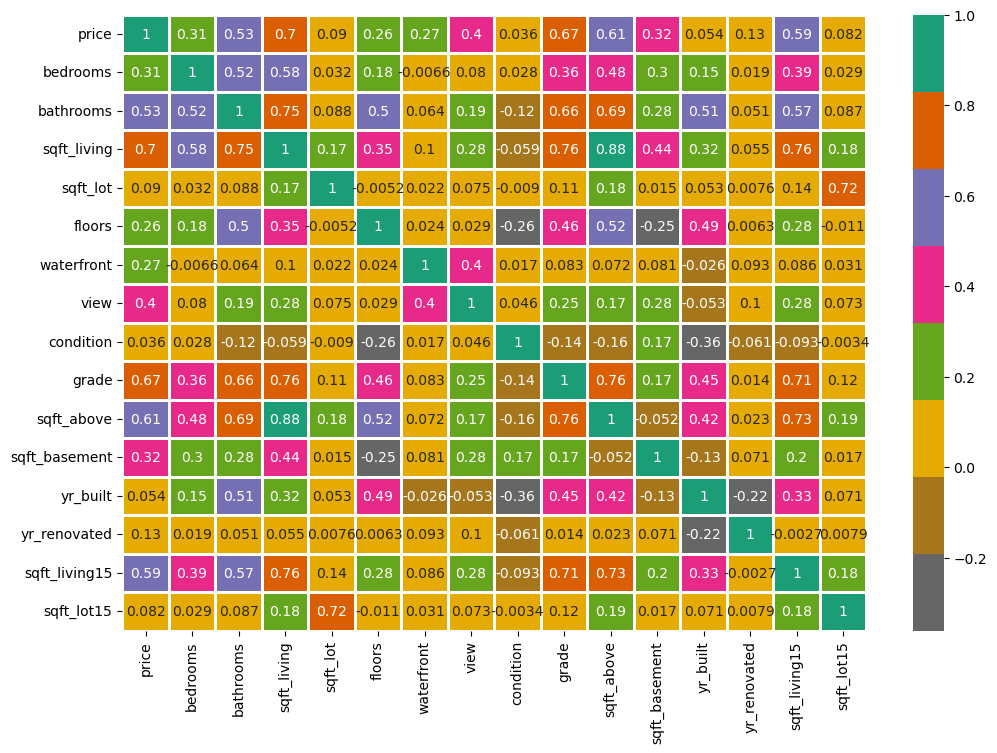

In [32]:
plt.figure(figsize=(12,8)) 
sns.heatmap(df.corr(), annot=True, cmap='Dark2_r', linewidths = 2)
plt.show()

Definimos las Xs y Ys

In [33]:
columns = df.columns.drop('price')

features = columns
label = ['price']

X = df[features]
y = df[label]

In [34]:
y.shape

(21613, 1)

In [35]:
X.shape

(21613, 15)

Generamos la partición de los datos

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 101)
scores = {
    'MAE': [], 
    'R2': [],
    'res': [],
    'names': ["Modelo Lineal", "Modelo Cuadrático", "Modelo Ridge", "Modelo Lasso"]}

print(f'Numero total de registros en la bdd: {len(X)}')
print("*****"*10)
print(f'Numero total de registros en el training set: {len(X_train)}')
print(f'Tamaño de X_train: {X_train.shape}')
print("*****"*10)
print(f'Mumero total de registros en el test dataset: {len(X_test)}')
print(f'Tamaño del X_test: {X_test.shape}')

Numero total de registros en la bdd: 21613
**************************************************
Numero total de registros en el training set: 19451
Tamaño de X_train: (19451, 15)
**************************************************
Mumero total de registros en el test dataset: 2162
Tamaño del X_test: (2162, 15)


In [37]:
X_test.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
3834,2,1.00,1050,6317,1.5,0,0,4,7,1050,0,1913,0,1600,9616
1348,4,2.25,2040,9565,1.0,0,0,3,8,1400,640,1959,0,1890,8580
20366,4,2.50,2500,4000,2.0,0,0,3,8,2500,0,2014,0,1480,4300
16617,5,2.00,2360,19899,1.0,0,0,4,7,2360,0,1968,0,1860,19998
20925,3,3.00,1670,4440,1.0,0,0,3,7,1670,0,2014,0,1670,4622


Ahora entrenamos los modelos

In [38]:
mlr_model = LinearRegression()

mlr_model.fit(X_train, y_train)
y_pred = mlr_model.predict(X_test)

scores["MAE"].append(mean_absolute_error(y_test, y_pred))
scores["R2"].append(r2_score(y_test, y_pred))
scores["res"].append(y_test.values.flatten() - y_pred.flatten())

Obtenemos su ecuación

In [39]:
get_linear_model_eq(mlr_model)

[array([[-3.82008048e+04,  4.14661380e+04,  1.07992584e+02,
          1.71356997e-02,  3.16916913e+04,  5.52691023e+05,
          4.12493228e+04,  2.12221443e+04,  1.19493216e+05,
          4.77750270e+01,  6.02175564e+01, -3.55090216e+03,
          1.32602215e+01,  2.90059284e+01, -5.48132603e-01]]),
 array([6151359.26274254])]

La ecuación del modelo lineal es: $\hat{y} =  -38,200X_1 + 41,466X_2 + 107.99X_3 + ... - 0.548X_{15} + 6,151,359.26$

In [40]:
print_metrics(y_test, y_pred)

Error medio Absoluto (MAE): 137480.13882730895
Root Mean Squared Error: 232133.36762408607
r2_score 0.6579723205007484


Hacemos lo mismo para el modelo polinomial

In [41]:
#polinomial
pipe = Pipeline(steps = [
    ("pol_transform", PolynomialFeatures(include_bias=False)),
    ('model', LinearRegression())
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test) 

scores["MAE"].append(mean_absolute_error(y_test, y_pred))
scores["R2"].append(r2_score(y_test, y_pred))
scores["res"].append(y_test.values.flatten() - y_pred.flatten())


Para sacar la ecuación, obtenemos cada uno de sus términos.

In [42]:
pipe.named_steps['pol_transform'].get_feature_names_out(X_train.columns)

array(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15', 'bedrooms^2', 'bedrooms bathrooms',
       'bedrooms sqft_living', 'bedrooms sqft_lot', 'bedrooms floors',
       'bedrooms waterfront', 'bedrooms view', 'bedrooms condition',
       'bedrooms grade', 'bedrooms sqft_above', 'bedrooms sqft_basement',
       'bedrooms yr_built', 'bedrooms yr_renovated',
       'bedrooms sqft_living15', 'bedrooms sqft_lot15', 'bathrooms^2',
       'bathrooms sqft_living', 'bathrooms sqft_lot', 'bathrooms floors',
       'bathrooms waterfront', 'bathrooms view', 'bathrooms condition',
       'bathrooms grade', 'bathrooms sqft_above',
       'bathrooms sqft_basement', 'bathrooms yr_built',
       'bathrooms yr_renovated', 'bathrooms sqft_living15',
       'bathrooms sqft_lot15', 'sqft_living^2', 'sqft_living sqft_lot',
       'sqft_livin

In [43]:
get_linear_model_eq(pipe.named_steps['model'])

[array([[ 9.33759792e+05, -1.09256281e+06, -4.87073481e+02,
         -2.78640773e+01, -2.07411510e+06, -3.95442052e+06,
         -2.88609605e+05,  5.58561365e+05,  1.09858962e+06,
         -1.89460489e+02, -3.51919037e+02, -8.59710910e+04,
         -2.95368812e+03,  3.99969066e+03, -3.40093880e+01,
          9.57190309e+02,  7.49943875e+03, -1.35831412e+01,
         -1.85900279e-02,  8.57794789e+03, -1.14902590e+04,
         -3.10213305e+02, -5.24211970e+03, -5.36750775e+03,
         -1.42102923e+00, -1.48183565e+01, -4.67026618e+02,
         -9.12924954e+00,  1.72777392e+01,  2.15712937e-01,
         -9.63321067e+03,  1.54490102e+01, -1.35669703e-01,
         -2.59057884e+04,  4.33659178e+04,  3.82998703e+03,
         -1.08104637e+03,  2.22965624e+04,  1.43684650e+01,
          1.27598335e+00,  5.03027728e+02, -1.70867076e+01,
         -1.72873779e+01, -5.60495383e-02,  6.38849872e+00,
          1.16959192e+00,  4.83302023e+00,  1.60302970e+02,
         -1.42698253e+01,  1.31168769e+0

La ecuación del modelo polinómico es: $\hat{y} =  9.34 \times 10^5X_1 - 1.09 \times 10^6X_2 + 4.26 \times 10^3X_3 + ... + 1.11 \times 10^{-4}X_{14}X_{15} + 2.35 \times 10^{-6}X_{15}^2 + 80,231,985.72$

In [44]:
print_metrics(y_test, y_pred)

Error medio Absoluto (MAE): 121314.02630524807
Root Mean Squared Error: 186263.26544801242
r2_score 0.7797882262461182


Ahora entrenemos los modelos Ridge y Lasso

In [45]:
lr_ridge = Ridge()

lr_ridge.fit(X_train, y_train)

y_pred = lr_ridge.predict(X_test)

scores["MAE"].append(mean_absolute_error(y_test, y_pred))
scores["R2"].append(r2_score(y_test, y_pred))
scores["res"].append(y_test.values.flatten() - y_pred.flatten())

In [46]:
get_linear_model_eq(lr_ridge)

[array([[-3.82192265e+04,  4.14509656e+04,  1.08015168e+02,
          1.69318239e-02,  3.16891574e+04,  5.48258333e+05,
          4.14559235e+04,  2.12264347e+04,  1.19470568e+05,
          4.78054716e+01,  6.02053443e+01, -3.55050129e+03,
          1.33171890e+01,  2.89851987e+01, -5.47998512e-01]]),
 array([6150751.38368672])]

La ecuación del modelo ridge es: $\hat{y} =  -38,219X_1 + 41,450X_2 + 1,080X_3 + ... - 0.548X_{15} + 6,150,751.38$

In [47]:
print_metrics(y_test, y_pred)

Error medio Absoluto (MAE): 137491.04339403284
Root Mean Squared Error: 232165.24266477523
r2_score 0.657878384029501


In [48]:
lr_lasso = Lasso(max_iter=1000, tol=0.1 )
lr_lasso.fit(X_train, y_train)

y_pred = lr_lasso.predict(X_test)

y_pred

scores["MAE"].append(mean_absolute_error(y_test, y_pred))
scores["R2"].append(r2_score(y_test, y_pred))
scores["res"].append(y_test.values.flatten() - y_pred.flatten())

In [49]:
get_linear_model_eq(lr_lasso)

[array([-3.81995388e+04,  4.14618764e+04,  2.93483794e+02,  1.71281550e-02,
         3.16871401e+04,  5.52541107e+05,  4.12549653e+04,  2.12193878e+04,
         1.19491830e+05, -1.37711515e+02, -1.25271769e+02, -3.55085021e+03,
         1.32628425e+01,  2.90053345e+01, -5.48136040e-01]),
 array([6151280.47002667])]

La ecuación del modelo lasso es: $\hat{y} =  -38,199X_1 + 41,4618X_2 + 2,934X_3 + ... - 0.548X_{15} + 6,151,280.47$

In [50]:
print_metrics(y_test, y_pred)

Error medio Absoluto (MAE): 137480.57126997688
Root Mean Squared Error: 232134.52702878078
r2_score 0.6579689039347314


Comparemos las métricas de los modelos

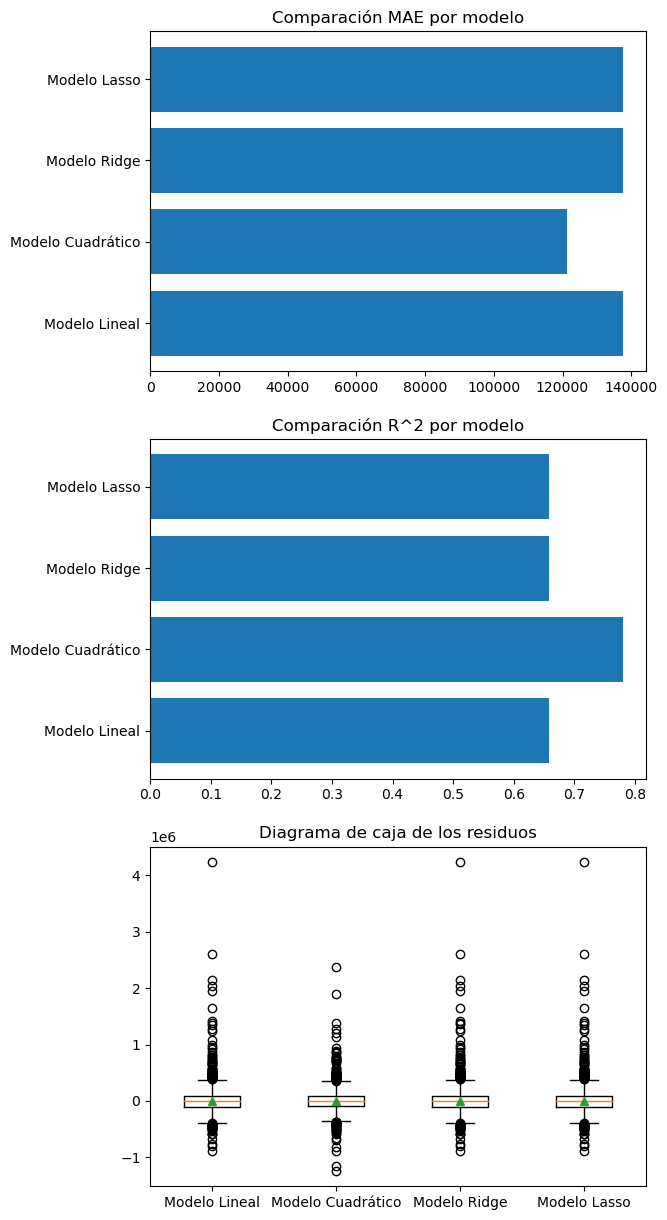

In [51]:
#scores['res']
display_metric_plots(scores)



Al igual que en el ejercicio 1, el modelo cuadrático tuvo mejor desempeño. También se observa la presencia de atípicos en los residuos. Exploremos ahora la distribución de estos residuos.

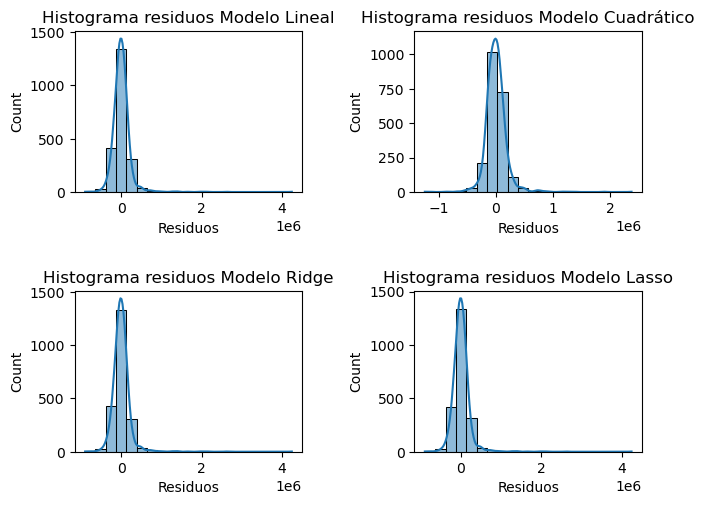

In [52]:
fig, ax = plt.subplots(2,2)
plt.tight_layout(h_pad=5, w_pad=5)
count = 0
for i in range(2):
    for j in range(2):
        ax[i][j].set_title(f'Histograma residuos {scores["names"][count]}')
        ax[i][j].set_xlabel('Residuos')
        sns.histplot(scores['res'][count], bins = 20, kde=True, ax= ax[i][j])
        count = count + 1

Se observa una distribución leptocúrtica sesgada a la derecha, esto debido a los atípicos que se visualizaron en el diagrama de caja.

### **Conclusiones** ###

* Se eligió una partición de los datos de entrenamiento/prueba de 90/10 respectivamente. Esto para mantener un equilibrio entre sesgo y varianza, ya que el contar con más datos de entrenamiento disminuye la varianza, pero si se tiene muy pocos datos para validación entonces el sesgo aumenta.
  
* El modelo que mostró mejor desempeño fue el cuadrático, ya que este presenta el menor error entre todos los modelos, así como un coeficiente de determinación más alto. Por ejemplo, el modelo cuadrático explica alrededor del 80% de la variación de los datos, con un MAE de 1,200,000.00. Los demás modelos explican menos del 70% de la variación y su MAE de la cifra anterior.
  
* Aunque la tolerancia al error dependerá del negocio, se puede observar a primera vista que una diferencia de cerca de 1,200,000.00 entre el precio real y las predicciones es bastante alta. También, esta conclusión puede complementarse al analizar los residuos del modelo. Por ejemplo, en el diagrama de caja se evidencia la presencia de valores atípicos en todos los modelos. También en el histograma se observa que estos valores atípicos están sesgando el modelo hacia la derecha.
  
* Lo anterior puede deberse a que no se aplicó ningún tipo de escalamiento a las variables de entrada. Por ejemplo, se tienen variables como número de habitaciones con rangos que van de 1 a 30 y variables como pies cuadrado que tienen un rango mucho mayor. 
  
* Otro punto que se observa es la presencia de variables dependientes correlacionadas, como el número de baños y los pies cuadrados del inmueble. Es importante dar tratamiento a estas variables correlacionadas antes de elegir un modelo. Por ejemplo, podrían reducirse las dimensiones por medio de un PCA.
  
* Por tanto, se sugiere aplicar primero un escalamiento de los datos, así como un análisis exploratorio para identificar atípicos y otros patrones que deban ser tomados en cuenta antes de entrenar el modelo.